In [2]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

In [50]:
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [21]:
df = pd.read_csv('data/FruitflyDataReduced.csv')
df.CompanionNumber = df.CompanionNumber.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.1 KB


In [17]:
df.head()

   Longevity CompanionNumber  Thorax
0         35       Pregnant8    0.64
1         37       Pregnant8    0.68
2         49       Pregnant8    0.68
3         46       Pregnant8    0.72
4         63       Pregnant8    0.72

In [39]:
df.CompanionNumber.cat.categories

Index(['None0', 'Pregnant1', 'Pregnant8', 'Virgin1', 'Virgin8'], dtype='object')


In [66]:
cat_idx = df.CompanionNumber.cat.codes.values
cat_idx

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [41]:
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

In [73]:
X = df.CompanionNumber.cat.codes.values
y = df.Longevity

yMean = y.mean()
ySD = y.std()

Ntotal = len(y)
NxLvl = len(df.CompanionNumber.cat.categories)

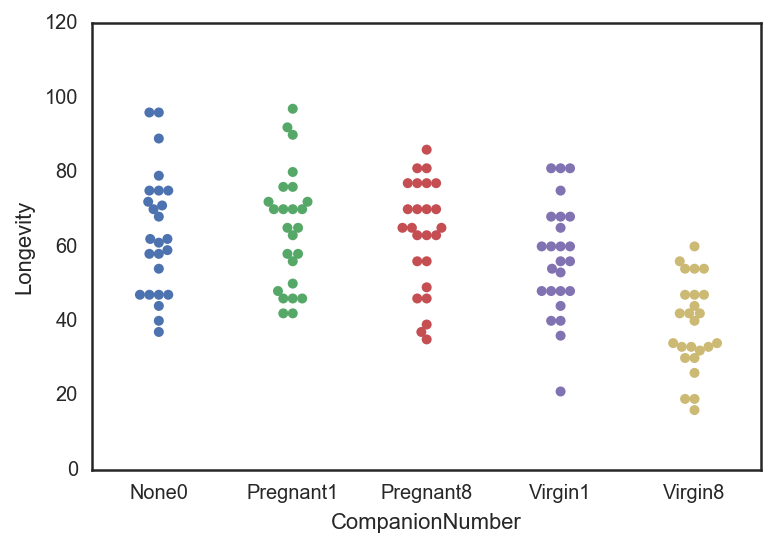

In [74]:
sns.swarmplot('CompanionNumber', 'Longevity', data=df);

In [ ]:
  #------------------------------------------------------------------------------
  # THE DATA.
  # Convert data file columns to generic x,y variable names for model:
  y = as.numeric(datFrm[,yName])
  x = as.numeric(as.factor(datFrm[,xName]))
  xlevels = levels(as.factor(datFrm[,xName]))
  Ntotal = length(y)
  NxLvl = length(unique(x))
  # Compute scale properties of data, for passing into prior to make the prior
  # vague on the scale of the data. 
  # For prior on baseline, etc.:
  yMean = mean(y)
  ySD = sd(y)
  # For hyper-prior on deflections:
  agammaShRa = unlist( gammaShRaFromModeSD( mode=sd(y)/2 , sd=2*sd(y) ) )
  # Specify the data in a list for sending to JAGS:
  dataList = list(
    y = y ,
    x = x ,
    Ntotal = Ntotal ,
    NxLvl = NxLvl ,
    # data properties for scaling the prior:
    yMean = yMean ,
    ySD = ySD ,
    agammaShRa = agammaShRa 
  )
  #------------------------------------------------------------------------------
  # THE MODEL.
  modelstring = "
  model {
    for ( i in 1:Ntotal ) {
      y[i] ~ dnorm( a0 + a[x[i]] , 1/ySigma^2 )
    }
    ySigma ~ dunif( ySD/100 , ySD*10 )
    a0 ~ dnorm( yMean , 1/(ySD*5)^2 ) 
    #
    for ( j in 1:NxLvl ) { a[j] ~ dnorm( 0.0 , 1/aSigma^2 ) }
    aSigma ~ dgamma( agammaShRa[1] , agammaShRa[2] ) 
    # Convert a0,a[] to sum-to-zero b0,b[] :
    for ( j in 1:NxLvl ) { m[j] <- a0 + a[j] } # cell means 
    b0 <- mean( m[1:NxLvl] )
    for ( j in 1:NxLvl ) { b[j] <- m[j] - b0 }
  }
  " # close quote for modelstring
  

In [87]:
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    m = a0 + a
    
    b0 = pmc.Deterministic('b0', m/5)
    b = pmc.Deterministic('b', m - b0)  
    
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    
    y = pmc.Normal('y', a0 + a[cat_idx], tau=1/ySigma**2, observed=y)

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [88]:
with model:
    trace = pmc.sample(100)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to ySigma_interval_
 [-----------------101%-----------------] 101 of 100 complete in 53.2 sec

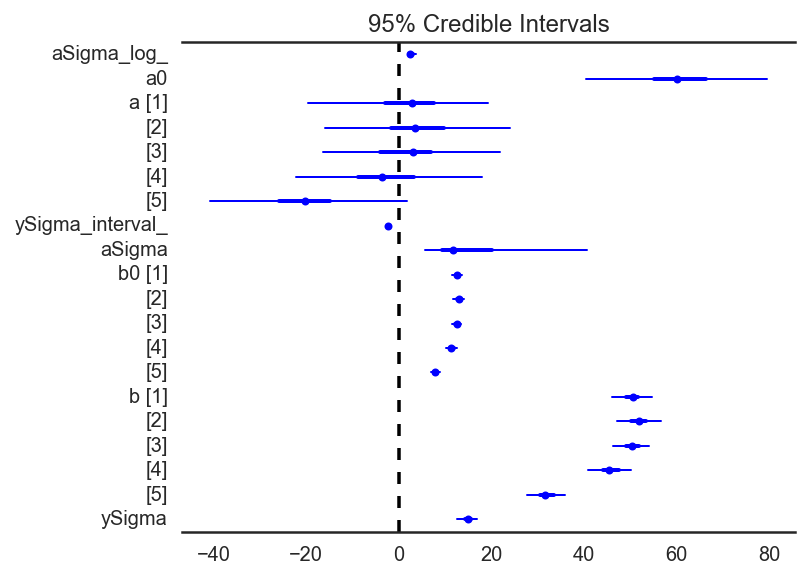

In [89]:
pmc.forestplot(trace)

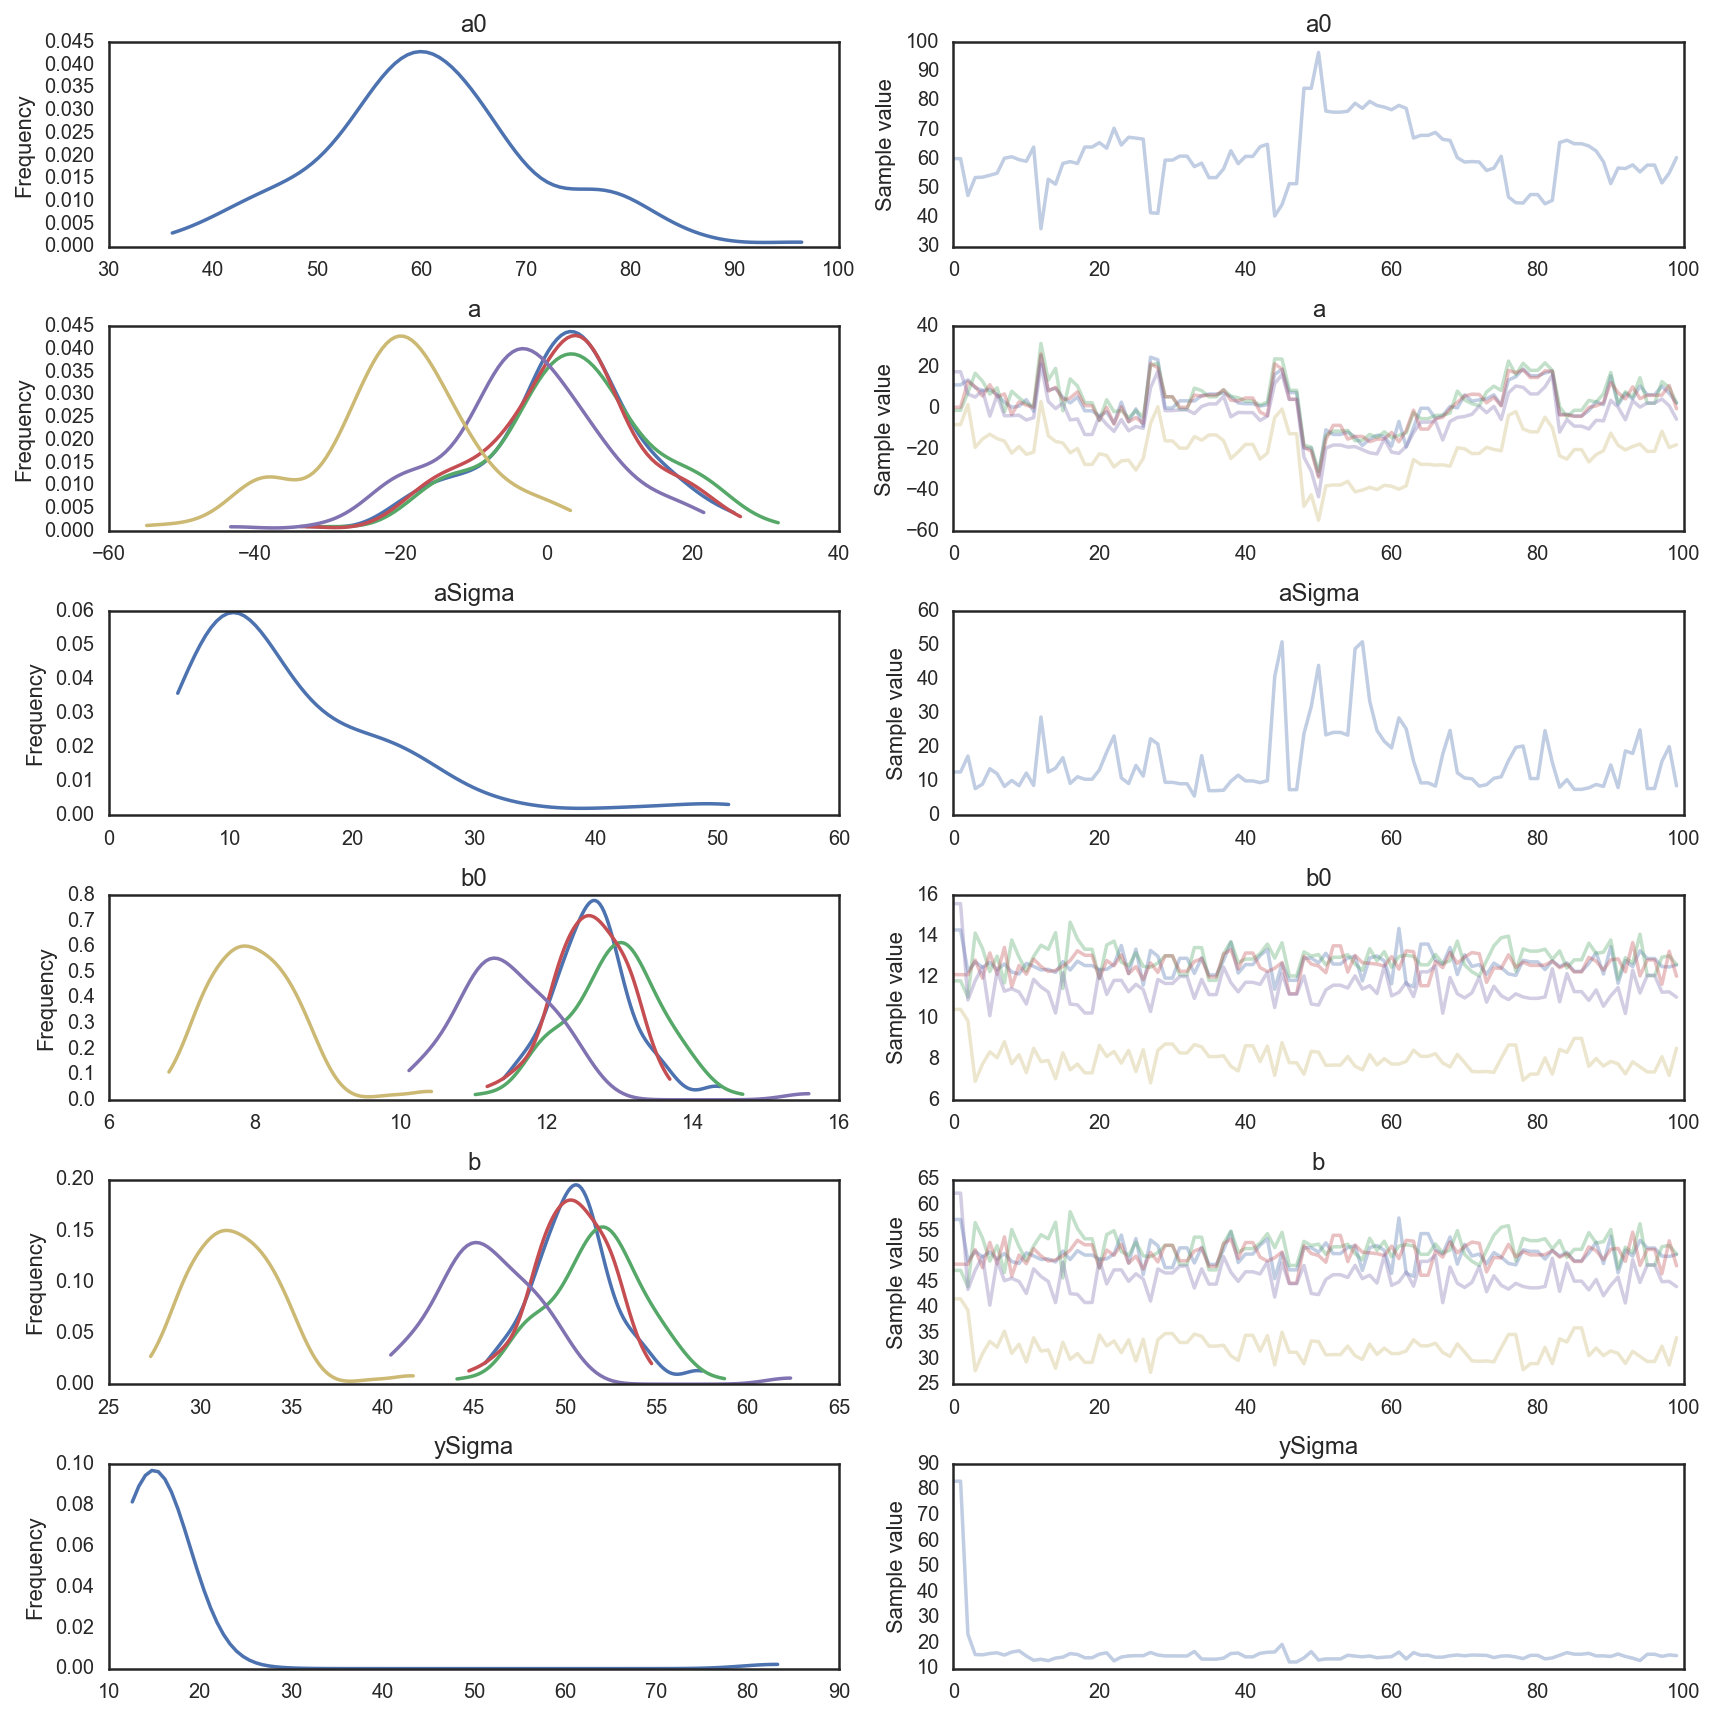

In [90]:
pmc.traceplot(trace);